In [78]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Concatenate, TimeDistributed, LSTM, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.autograph.experimental import do_not_convert
from sklearn.model_selection import train_test_split
import numpy as np
from helper_funcs import gen_samples, gen_simple_samples
from scipy.fft import rfftfreq
import pickle
import matplotlib.pyplot as plt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# # First navigate to our directory
# transfer_directory_path = os.path.join("Data", "synth_transfer_df.parquet")
# general_directory_path = os.path.join("Data", "synth_general_df.parquet")
# # Load the dataframes
# synth_transfer_df = pd.read_parquet(transfer_directory_path)
# synth_general_df = pd.read_parquet(general_directory_path)
# # Concatenate (after making sure they share columns) and then reset indices
# assert list(synth_transfer_df.columns) == list(synth_general_df.columns), "Column names do not match!"
# df = pd.concat([synth_transfer_df, synth_general_df], axis=0)
# df.reset_index(drop=True, inplace=True)
df = pd.read_parquet(os.path.join("Data", "synth_simple_df.parquet"))

In [190]:
rs=1
# Split into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['species'],  # Stratify based on the 'species' column
    random_state=rs
)

# Split temp into test (15%) and validation (15%)
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['species'],  # Stratify again to maintain balance
    random_state=rs
)

In [195]:
# Prepare samples
print("Generating Training Samples")
X_train, y_train, mins_maxes_train, isolated_peaks_train = gen_simple_samples(train_df)
print("Generating Test Samples")
X_test, y_test, mins_maxes_test, isolated_peaks_test = gen_simple_samples(test_df)
print("Generating Validation Samples")
X_val, y_val, mins_maxes_val, isolated_peaks_val = gen_simple_samples(val_df)

M = 194
# y_train=y_train[0:M, :]
# y_test=y_test[0:M, :]
# y_val=y_val[0:M, :]

# X_train=X_train[0:M, :]
# X_val=X_val[0:M, :]
# X_test=X_test[0:M, :]



Generating Training Samples
HEY
Generating Test Samples
HEY
Generating Validation Samples
HEY


In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [196]:
# Check for NaNs row-wise in y_train
rows_with_nans = np.isnan(y_train).any(axis=1)  # Check if any NaN exists in each row
nan_counts_per_row = np.isnan(y_train).sum(axis=1)  # Count NaNs per row

# Indices of rows with NaNs
rows_with_nans_indices = np.where(rows_with_nans)[0]

# Print results
print(f"Total rows with NaNs: {len(rows_with_nans_indices)}")
print("Rows with NaNs and their counts:")
for row in rows_with_nans_indices:
    print(f"Row {row}: {nan_counts_per_row[row]} NaN(s)")


Total rows with NaNs: 0
Rows with NaNs and their counts:


In [194]:
print(np.isnan(X_train).sum())  # Number of NaNs in X_train

4601


In [189]:
print(X_train)

X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

[[[  3.67294064]
  [  3.60661585]
  [  3.58885795]
  ...
  [-19.89845176]
  [-20.09981864]
  [-20.46548765]]

 [[ 19.018747  ]
  [ 19.02506527]
  [ 19.04001764]
  ...
  [-17.05451871]
  [-16.63582555]
  [-15.73915122]]

 [[  6.6156298 ]
  [  6.59374089]
  [  6.61934246]
  ...
  [-23.48201557]
  [-22.86109186]
  [-22.41976817]]

 ...

 [[ 12.03268805]
  [ 12.04365538]
  [ 12.04813922]
  ...
  [-22.14698404]
  [-21.51027824]
  [-21.88970207]]

 [[ -0.37740172]
  [ -0.37851627]
  [ -0.3814507 ]
  ...
  [-25.19748294]
  [-25.72138349]
  [-25.62720785]]

 [[  4.61453233]
  [  4.64080411]
  [  4.63814926]
  ...
  [-19.73206677]
  [-19.3860967 ]
  [-19.74231724]]]


In [176]:
# Print the data types of the variables
print("X_train dtype:", X_train.dtype)
print("X_val dtype:", X_val.dtype)
print("X_test dtype:", X_test.dtype)

print("y_train dtype:", y_train.dtype)
print("y_val dtype:", y_val.dtype)
print("y_test dtype:", y_test.dtype)

X_train dtype: float64
X_val dtype: float64
X_test dtype: float64
y_train dtype: float64
y_val dtype: float64
y_test dtype: float64


In [177]:

# Verify the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (700, 8192, 1)
Shape of X_val: (150, 8192, 1)
Shape of X_test: (150, 8192, 1)
Shape of y_train: (700, 8192, 1)
Shape of y_val: (150, 8192, 1)
Shape of y_test: (150, 8192, 1)


In [178]:
print(y_train[192:, :, 0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


In [183]:
print(X_train[192:, :, 0])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [179]:
# M = 200
# N = 8192
# X_train = np.random.rand(M, N, 1)
# y_train = np.random.randint(0, 2, size=(M, N, 1))
# X_val = np.random.rand(M, N, 1)
# y_val = np.random.randint(0, 2, size=(M, N, 1))

In [180]:
# Set model parameters 
k=3
peak_encourage=5
include_LSTM=False
epochs = 3
lr = 0.001
model_version = f"SIMPLE_V1_k-{k}_PE-{peak_encourage}_LSTM-{include_LSTM}_Epochs-{epochs}_LR-{lr}"
batch_size = 32
patience = 3
threshold_list = [0.05, 0.1, 0.15, 0.2]

In [181]:
# DEFINE MODEL STRUCTURE
# Define the input length / number of frequency bins (N)
N = 8192

# Input layer
input_layer = Input(shape=(N, 1), name="Input")

x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
output_layer = Conv1D(1, kernel_size=1, activation='sigmoid', name="Output", padding='same')(x)

# Define the model to output both predictions and weights
model = tf.keras.Model(
    inputs=input_layer, 
    outputs=output_layer,  # Explicitly define both outputs
    name=model_version
)


# Compile the model (lambda function in loss to allow for prominences to be passed in as weights)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy'
)

model.summary()


Model: "SIMPLE_V1_k-3_PE-5_LSTM-False_Epochs-3_LR-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8192, 1)]         0         
                                                                 
 conv1d_34 (Conv1D)          (None, 8192, 16)          64        
                                                                 
 conv1d_35 (Conv1D)          (None, 8192, 32)          1568      
                                                                 
 Output (Conv1D)             (None, 8192, 1)           33        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [182]:
# TRAIN MODEL
start_time = time.time()
model_path = os.path.join("PP Model", f"{model_version}.keras")

# Add callbacks for better training
callbacks = [
    # ValidationMetricCallback(validation_data=(X_val, (y_val, isolated_peaks_val)), metric_name="peak_counting_error"),
    # EarlyStopping(monitor="peak_counting_error", patience=patience, restore_best_weights=True, verbose=1),  # Stop if no improvement for 5 epochs
    # ModelCheckpoint(model_path, save_best_only=True, monitor='peak_counting_error'),  # Save the best model
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'),  # Save the best model
]

print(X_train.shape) 
print(X_train[0, :])
print(X_val.shape) 
print(X_val[0, :])

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)


with open(os.path.join("PP Model", f"{model_version}_history.pkl"), 'wb') as file:
    pickle.dump(history.history, file)
    
elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

(700, 8192, 1)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
(150, 8192, 1)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
Epoch 1/3
22/22 [==============================] - 2s 60ms/step - loss: nan - val_loss: nan
Epoch 2/3
22/22 [==============================] - 1s 57ms/step - loss: nan - val_loss: nan
Epoch 3/3
22/22 [==============================] - 1s 57ms/step - loss: nan - val_loss: nan
Execution time: 4.34 seconds


In [170]:
# model = load_model(os.path.join("PP Model", f"{model_version}.keras"))
# model = load_model(os.path.join("PP Model", "V1_k-3_PE-1_LSTM-False_Epochs-15_LR-0.001.keras"), custom_objects={"custom_loss": custom_loss})

In [171]:
# Assuming the predicted values are probabilities from 0 to 1
sample_idx = 5
val_pred = model.predict(X_val)  # Predicted probabilities or binary values
val_pred[sample_idx, :]


5/5 [==============================] - 0s 6ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [172]:
print(val_pred[sample_idx, :].shape)

(8192, 1)


(150, 8192, 1)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


ValueError: x and y can be no greater than 2D, but have shapes (8192,) and (8192, 1, 1)

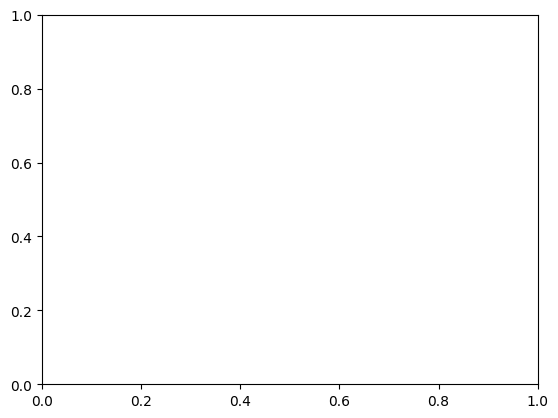

In [173]:
# CHECKING PREDICTIONS

sample_idx = 5
spectrum = X_val[sample_idx, :]
# predicted_peaks = val_pred[sample_idx, :, 2] 
predicted_peaks = val_pred[sample_idx, :]
print(val_pred.shape)
print(predicted_peaks)


# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Add colors depending on percentage of prediction
scatter = plt.scatter(f, spectrum, c=predicted_peaks, cmap='viridis', s=50)

# Add color bar
plt.colorbar(scatter, label='Predicted Peaks Value')

# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum with Scatter Points Colored by Predicted Peaks Value')
plt.show()

In [10]:
best_error, best_thresh = peak_counting_error(isolated_peaks_val, val_pred)

Peak counting error for threshold 0.05: 401.71552471812663
Peak counting error for threshold 0.1: 401.71552471812663
Peak counting error for threshold 0.15: 436.7172593235039
Peak counting error for threshold 0.2: 436.7172593235039
Best threshold: 0.05, Best Peak Counting Error: 401.71552471812663


[0.02368795 0.02368795 0.02368795 ... 0.02368795 0.02368795 0.02368795]


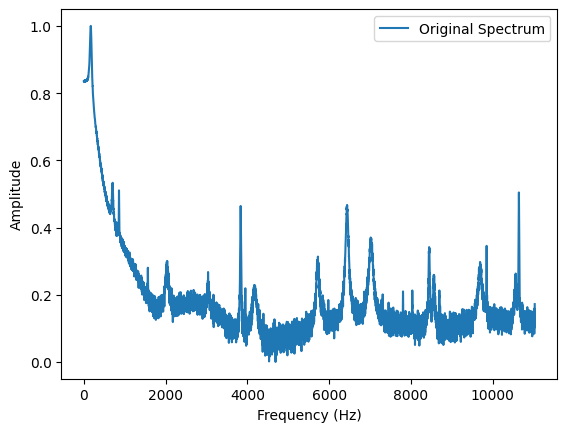

In [12]:
sample_idx = 0
thresh = best_thresh
spectrum = X_val[sample_idx, :]
predicted_peaks = val_pred[sample_idx, :] 

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(predicted_peaks > thresh)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Predicted Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Get validation counting accuracy
val_peak_counting_accuracy = peak_counting_accuracy(isolated_peaks_val, val_pred)

print("Test Loss:", test_loss)


In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
# CHECKING PEAK LABELS FOR ERRORS

sample_idx = 0
spectrum = X_train[sample_idx, :]
peak_labels = y_train[sample_idx, :, 0]

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(peak_labels==1)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Labeled Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Verify Custom Loss
# Example data: batch_size=4, N=5, nodes=3
y_true = np.array([
    [[0, 0.5, 0.7], [0, 0.2, -1], [0, 10000, -1000], [0, 0.3, 10], [0, 0.1, 10]],  # Sample 1
    [[0, 0.6, 0.3], [1, 0.1, -1], [1, 0.3, 10], [0, 0.4, 10], [0, 0.7, 10]],  # Sample 2
    [[0, 0.4, 1.5], [1, 0.8, -1], [1, 0.6, 10], [1, 0.2, 10], [0, 0.9, 10]],  # Sample 3
    [[0, 0.5, 0.6], [0, 0.3, -1], [0, 0.7, 10], [1, 0.1, 10], [0, 0.8, 10]],  # Sample 4
])

y_pred = np.array([
    [[0.9, 0.6, 0.8], [0.9, 0.3, 0.5], [0.5, 100000, 1000], [0.7, 0.4, 0.6], [0.2, 0.1, 0.3]],  # Sample 1
    [[0.7, 0.5, 0.4], [0.9, 0.2, 0.3], [0.9, 0.4, 0.6], [0.6, 0.7, 0.9], [0.8, 0.7, 0.8]],  # Sample 2
    [[0.8, 0.4, 0.5], [0.9, 0.6, 0.8], [0.9, 0.7, 0.5], [0.9, 0.3, 0.6], [0.2, 0.9, 0.7]],  # Sample 3
    [[0.9, 0.4, 0.3], [0.9, 0.6, 0.8], [0.6, 0.9, 0.7], [0.9, 0.3, 0.5], [0.8, 0.7, 0.6]],  # Sample 4
])

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

loss_value = custom_loss(y_true_tensor, y_pred_tensor)
print("Loss Value:", loss_value.numpy())

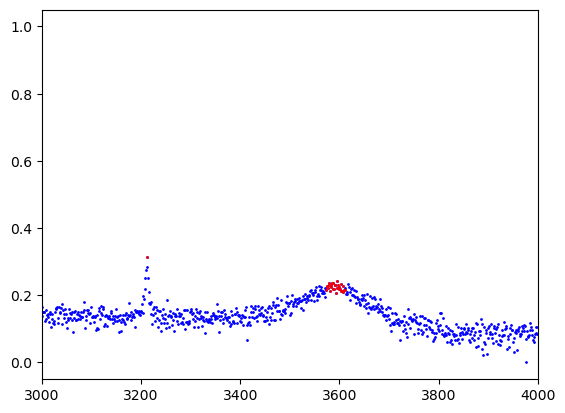

In [56]:
# Plot a sample
i = 1
spectrum = X_train[i]
f = rfftfreq(32768, 1/44100)[0:8192]

labels = y_train[i, :, :]
spread_peak_labels = labels[:, 0]
indices = np.where(spread_peak_labels == 1)[0]
# isolated_peaks = isolated_peaks_train[i]
# indices = np.where(isolated_peaks == 1)[0]
plt.scatter(f, spectrum, color='blue', s=1)
plt.scatter(f[indices], spectrum[indices], color='red', s=1)
plt.xlim(3000, 4000)
plt.show()

In [ ]:
# Verify peak_counting_error
isolated_peaks_val=np.array(
    [[0, 1, 0, 0, 1], 
     [1, 0, 1, 0, 0]]
    )
val_predictions=np.array(
    [[0.81, 0.91, 0.71, 0.31, 0.91],
     [0.81, 0.21, 0.91, 0.96, 0.91]]
    )

peak_counting_error(isolated_peaks_val, val_predictions)

In [ ]:
# Figure out how many bins our peaks are
f = rfftfreq(32768, 1/44100)
# HWFM (in bins) of a peak with a HWHM of 100Hz
bin_width = f[1] - f[0]
print(f"HWFM (in bins) of a peak with a HWHM of 100Hz: {200 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 10Hz: {20 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 3Hz: {6 / bin_width}")

In [ ]:
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss function for (batch_size, N, 3):
#     - Binary cross-entropy for the first output node.
#     - MSE for the second and third output nodes, masked by the first node's true labels.
#     - Each bin in each sample is weighted by f(SNR), where SNR is the 3rd node label.
    
#     Args:
#     y_true: Tensor of true labels, shape (batch_size, N, 3).
#     y_pred: Tensor of predicted values, shape (batch_size, N, 3).
    
#     Returns:
#     A scalar tensor representing the combined loss.
#     """

    # # Mean squared error for the second and third nodes
    # mse_loss_2 = tf.square(y_true[..., 1] - y_pred[..., 1])
    # mse_loss_3 = tf.square(y_true[..., 2] - y_pred[..., 2])
    # mse_loss = mse_loss_2 + mse_loss_3  # Shape (batch_size, N)

    # # Mask the MSE loss where the first node's true label is 0
    # mask = tf.cast(y_true[..., 0] > 0, tf.float32)  # Shape (batch_size, N)
    # masked_mse_loss = mse_loss * mask  # Shape (batch_size, N)
    
    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(SNR), where SNR is the 3rd node label
    # snr = y_true[..., 2]  # SNR is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(snr < 0, tf.ones_like(snr), weight_func(snr))  # If SNR < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func

    # # Apply weights to the masked MSE loss
    # weighted_mse_loss = masked_mse_loss * weights  # Shape (batch_size, N)
    
    # # Apply weights to the BCE loss
    # weighted_bce_loss = bce_loss * weights  # Shape (batch_size, N)

    # # Average weighted MSE, BCE losses across bins (N) for each sample
    # mean_mse_loss_per_sample = tf.reduce_mean(weighted_mse_loss, axis=1)  # Mean over N for shape (batch_size,)
    # mean_bce_loss_per_sample = tf.reduce_mean(weighted_bce_loss, axis=1)

    # # Combine and average across the batch
    # total_loss = tf.reduce_mean(mean_bce_loss_per_sample + mean_mse_loss_per_sample)  # Mean over batch size

    # return total_loss




# class ValidationMetricCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, metric_name="peak_counting_error"):
#         super(ValidationMetricCallback, self).__init__()
#         self.validation_data = validation_data
#         self.metric_name = metric_name

#     def on_epoch_end(self, epoch, logs=None):
#         val_x, (val_y, isolated_peaks_val) = self.validation_data  # Unpack extra labels
#         val_predictions = self.model.predict(val_x, verbose=0)
        
#         # Compute your custom metric (e.g., Mean Absolute Error)
#         val_metric = peak_counting_error(isolated_peaks_val, val_predictions)

#         # Add the validation metric to logs
#         logs[self.metric_name] = val_metric.numpy()

#         print(f"Epoch {epoch + 1}: {self.metric_name} = {val_metric.numpy()}")


# for row_idx in range(y_train.shape[0]):
#     y_peak_labels = y_train[:, :, 0]
#     if tf.reduce_any(y_peak_labels[row_idx] < 0):  # Check if any value in the row is negative
#         print(f"Row {row_idx} contains negative values:")
#         print(y_peak_labels[row_idx])



    # # Check for any negative values or values greater than 1 in y_true
    # has_negative_y_true = tf.reduce_any(y_true < 0)
    # has_greater_one_y_true = tf.reduce_any(y_true > 1)
    
    # # Check for any negative values in y_pred
    # has_negative_y_pred = tf.reduce_any(y_pred < 0)
    
    # # Use tf.debugging.assert_* to enforce conditions during graph execution
    # tf.debugging.assert_equal(
    #     has_negative_y_true, False, message="y_true contains negative values."
    # )
    # tf.debugging.assert_equal(
    #     has_greater_one_y_true, False, message="y_true contains values greater than 1."
    # )
    # tf.debugging.assert_equal(
    #     has_negative_y_pred, False, message="y_pred contains negative values."


    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(prom), where prominence is the 3rd node label
    # prom = y_true[..., 2]  # prom is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(prom < 0, tf.ones_like(prom), weight_func(snr))  # If prom < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func
    


In [32]:
import tensorflow as tf

# Example data
batch_size = 2
bins_per_sample = 4

y_true = tf.constant([[1, 0, 1, 0], [0, 1, 0, 1]], dtype=tf.float32)  # Shape (batch_size, bins_per_sample)
y_pred = tf.constant([[0.9, 0.1, 0.8, 0.3], [0.2, 0.7, 0.3, 0.9]], dtype=tf.float32)  # Shape (batch_size, bins_per_sample)

# Compute element-wise binary cross-entropy
bce_loss = tf.keras.backend.binary_crossentropy(y_true, y_pred)  # Shape (batch_size, bins_per_sample)

# Print the result
tf.print("Element-wise BCE Loss:", bce_loss)


Element-wise BCE Loss: [[0.105360404 0.105360404 0.223143399 0.35667479]
 [0.223143399 0.35667479 0.35667479 0.105360404]]
